# Math2 dataset preprocessing
### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd
import numpy as np
from liriscat.dataset.preprocessing_utilities import *
from liriscat.utils import utils
import torch
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


### Load and merge dataset

In [33]:
raw_data_train = pd.read_csv('../1-raw_data/Eedi-2_train.csv', encoding="ISO-8859-15", low_memory=False)

raw_data_test = pd.read_csv('../1-raw_data/Eedi-2_test.csv', encoding="ISO-8859-15", low_memory=False)
raw_data = pd.concat([raw_data_train, raw_data_test], ignore_index=True)

raw_data = raw_data.drop(columns=['CorrectAnswer','AnswerValue','IsTarget'])

raw_data.head()

,QuestionId,UserId,AnswerId,IsCorrect
0,898,2111,280203,1
1,767,3062,55638,1
2,165,1156,386475,1
3,490,1653,997498,1
4,298,3912,578636,1


### Split rows with several dimensions

In [34]:
#Pas utile car aucune colonne ne contient de listes de valeurs
df_expanded = raw_data.explode('AnswerId').reset_index(drop=True)
df_expanded.head()

,QuestionId,UserId,AnswerId,IsCorrect
0,898,2111,280203,1
1,767,3062,55638,1
2,165,1156,386475,1
3,490,1653,997498,1
4,298,3912,578636,1


### Early stats

In [36]:
print("Total number of data :", len(raw_data))

#Etapes inutiles car il n'y a pas de lignes à supprimer
all_data = raw_data.dropna(subset=['QuestionId','UserId','AnswerId','IsCorrect'])
print(len(all_data))

Total number of data : 1434026
1434026


In [37]:
stat_unique(all_data, None)
stat_unique(all_data, ['QuestionId','UserId'])
stat_unique(all_data, 'UserId')
stat_unique(all_data, 'QuestionId')
stat_unique(all_data, 'AnswerId')

Total length: 1434026
Number of unique [QuestionId,UserId]: 1434026
Number of unique UserId: 5533
Number of unique QuestionId: 948
Number of unique AnswerId: 1434026


### Clean Nan values

In [41]:


cleaned_data = all_data.dropna(subset=['QuestionId','UserId','AnswerId','IsCorrect'], axis='index')

#print(len(raw_data))
#print(len(cleaned_data))

### Remove duplicated user and id rows

In [44]:
unduplicated_data = remove_duplicates(cleaned_data, key_attrs=['QuestionId','UserId','AnswerId'], agg_attrs=[])

### Filter Data

In [45]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 : 
    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'QuestionId','UserId',5)
    # filter users
    min_nb_users_logs = 20
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'UserId','QuestionId',min_nb_users_logs)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'AnswerId','QuestionId',1)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['UserId', 'QuestionId'])
stat_unique(filtered_data_0, 'UserId')
stat_unique(filtered_data_0, 'QuestionId')
stat_unique(filtered_data_0, 'AnswerId')

filter 0 QuestionId
filter 0 UserId
filter 0 AnswerId
Total length: 1434026
Number of unique [UserId,QuestionId]: 1434026
Number of unique UserId: 5533
Number of unique QuestionId: 948
Number of unique AnswerId: 1434026


### Encoding

In [10]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [11]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [12]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [13]:
q2k, k2q = create_q2k(d_enc_data)

### Rescaling responses

In [14]:
resc_data = d_enc_data
resc_data['correct'] = resc_data['correct'].astype(float)
min_val = resc_data['correct'].min()
max_val = resc_data['correct'].max()
resc_data['correct'] = (resc_data['correct']-min_val)/(max_val-min_val) +1
print(f'min value : {resc_data["correct"].min()}, max value : {resc_data["correct"].max()}')

min value : 1.0, max value : 2.0


### Get final stats and create metadata

In [15]:
stat_unique(resc_data, None)
stat_unique(resc_data, ['user_id', 'item_id'])
stat_unique(resc_data, 'user_id')
stat_unique(resc_data, 'item_id')
stat_unique(resc_data, 'dimension_id')
stat_unique(resc_data, 'correct')

resc_data_dim_grouped_items = resc_data.groupby("dimension_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("user_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

Total length: 250304
Number of unique [user_id,item_id]: 78220
Number of unique user_id: 3911
Number of unique item_id: 20
Number of unique dimension_id: 16
Number of unique correct: 13
#questions/category: 1 & 4 &  16
#users/category: 3911 & 3911 &  3911
#categorys/question: 2 & 3 &  5
#users/question: 3911 & 3911 &  3911
#questions/users: 20 & 20 &  20
#categorys/users: 16 & 16 &  16


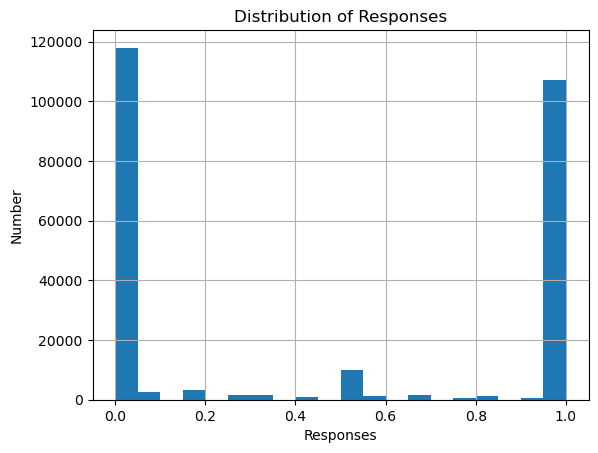

In [16]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(resc_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')
plt.savefig('../4-figs/distribution_math2.png')


In [17]:
resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
metadata = get_metadata(resc_data,["user_id", "item_id", "dimension_id"])
metadata['min_nb_users_logs'] = min_nb_users_logs
metadata['max_nb_categories_per_question'] = int(np.max(resc_data_dim_grouped_items))

### Compute nb of modalities per item

In [18]:
nb_modalities = get_modalities_nb(resc_data, metadata)

### Save data, concept map, metadata and nb_modalities

In [19]:
new_order = ['user_id','item_id', 'correct', 'dimension_id']
resc_data = resc_data[new_order]

In [20]:
# save selected data
resc_data.to_csv('../1-raw_data/math2_selected_data.csv', index=False)

In [21]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('../2-preprocessed_data/math2_concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [22]:
# save metadata
with open('../2-preprocessed_data/math2_metadata.json', 'w') as f:
    json.dump(metadata, f)

In [23]:
# save metadata
torch.save(nb_modalities,'../2-preprocessed_data/math2_nb_modalities.pkl')

## parse data

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from liriscat import utils
utils.setuplogger(verbose = True,log_path = "../../logs/", log_name="liriscat")
utils.set_seed(0)

In [37]:
import pandas as pd
from liriscat.dataset.preprocessing_utilities import *
resc_data = pd.read_csv('../1-raw_data/math2_selected_data.csv')

In [38]:
train, valid, test = split_users(resc_data, 5)

## save data

In [40]:
for i_fold, train_fold in enumerate(train):
    save_df_to_csv(train[i_fold], f'../2-preprocessed_data/math2_train_{i_fold}.csv')
    save_df_to_csv(valid[i_fold], f'../2-preprocessed_data/math2_valid_{i_fold}.csv')
    save_df_to_csv(test[i_fold], f'../2-preprocessed_data/math2_test_{i_fold}.csv')

## Train IMPACT model

In [41]:
from liriscat.utils import generate_eval_config
import json
from IMPACT.dataset import LoaderDataset as IMPACT_dataset
from liriscat.CDM import *
from IMPACT import model
from liriscat.dataset.preprocessing_utilities import *


folds_nb = 1
dataset_name="math2"

# Set all the required parameters ---------------
IMPACT_config = generate_eval_config(num_epochs=200, save_params=True, dataset_name=dataset_name, embs_path="../../embs/"+dataset_name, params_path="../../ckpt/"+dataset_name,  learning_rate=0.01885, lambda_=2e-7, batch_size=2048,valid_metric='mi_acc', pred_metrics=["mi_acc"])

concept_map = json.load(open(f'../2-preprocessed_data/{IMPACT_config["dataset_name"]}_concept_map.json', 'r'))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

metadata = json.load(open(f'../2-preprocessed_data/{IMPACT_config["dataset_name"]}_metadata.json', 'r'))


# Conversion helper that builds a DataFrame with specific dtypes and returns records.
def convert_to_records(data):
    df = pd.DataFrame(data, columns={'user_id': int, 'item_id': int, 'category_id': int,'correct': float, })
    return df.to_records(index=False, column_dtypes={'user_id': int, 'item_id': int, 'correct': float, 'category_id': int})

CUDA is available. Using GPU.


In [42]:
for i in range(folds_nb):
    # Merge the training and validation data for the current fold.
    train_valid_df = pd.concat([train[i], valid[i]])
    # Split the merged data horizontally into train and validation sets.

    quadruplet = quadruplet_format(train_valid_df)
    train_data, valid_data, test_data = split_data_vertically(quadruplet, test_prop=0.2,valid_prop=0.1,folds_nb=5)

    # Convert each split in one step using the helper.
    horizontal_train = convert_to_records(train_data[0])
    horizontal_valid = convert_to_records(valid_data[0])
    horizontal_test = convert_to_records(test_data[0])

    impact_train_data = IMPACT_dataset(horizontal_train, concept_map, metadata)
    impact_valid_data = IMPACT_dataset(horizontal_valid, concept_map, metadata)
    impact_test_data = IMPACT_dataset(horizontal_test, concept_map, metadata)

    IMPACT_config['i_fold'] = i
    algo = model.IMPACT(**IMPACT_config)
    algo.init_model(impact_train_data, impact_valid_data)
    algo.train(impact_train_data, impact_valid_data)
    print(algo.evaluate_predictions(impact_test_data))

[INFO 17:10] train on cuda
[INFO 17:10] -- START Training --


 46%|███████████████████                       | 91/200 [01:56<02:19,  1.28s/it]

[INFO 19:13] -- END Training --
[INFO 19:13] Params saved


{'mi_acc': 0.9761289954185486, 'preds': tensor([2., 1., 2.,  ..., 1., 1., 1.], device='cuda:0', dtype=torch.float64), 'labels': tensor([2., 1., 2.,  ..., 1., 1., 1.], device='cuda:0', dtype=torch.float64)}


In [7]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from liriscat import utils
utils.set_seed(0)
from liriscat import dataset
from liriscat import selectionStrategy
from liriscat import CDM

import logging
import gc
import json
import torch
import pandas as pd
from importlib import reload
import IMPACT

import warnings
import numpy as np

gc.collect()
torch.cuda.empty_cache()

reload(utils)
reload(selectionStrategy)
reload(CDM)
reload(dataset)

config = utils.generate_eval_config(i_fold = 0,
                                    num_epochs=1,
                                    load_params=True,
                                    inner_user_lr=0.0001,
                                    esc = 'error',
                                    valid_metric= 'mi_acc',
                                    pred_metrics = ["mi_acc"],
                                    profile_metrics = ['doa'],
                                    save_params=False,
                                    n_query=5,
                                    batch_size=512)
utils.set_seed(config["seed"])

config["dataset_name"] = "math2"
logging.info(config["dataset_name"])
config['learning_rate'] = 0.02026
config['lambda'] = 1.2e-5
config['d_in'] = 4
config['num_responses'] = 12
#pred_metrics,df_interp = test(config)

logging.info(f'#### {config["dataset_name"]} ####')
logging.info(f'#### config : {config} ####')
config['embs_path']='../../embs/'+str(config["dataset_name"])
config['params_path']='../../ckpt/'+str(config["dataset_name"])

pred_metrics = {m:[] for m in config['pred_metrics']}
profile_metrics = {m:[] for m in config['profile_metrics']}

gc.collect()
torch.cuda.empty_cache()

# Dataset downloading for doa and rm
warnings.filterwarnings("ignore", message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Concept map format : {question_id : [category_id1, category_id2, ...]}outside model initialization
concept_map = json.load(open(f'../2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

## Metadata map format : {"num_user_id": ..., "num_item_id": ..., "num_dimension_id": ...}
metadata = json.load(open(f'../2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'))

i_fold = 0
## Dataframe columns : (user_id, question_id, response, category_id)
train_df = pd.read_csv(
    f'../2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
valid_df = pd.read_csv(
    f'../2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
test_df = pd.read_csv(
    f'../2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
train_data = dataset.CATDataset(train_df, concept_map, metadata, config)
valid_data = dataset.EvalDataset(valid_df, concept_map, metadata, config)
test_data = dataset.EvalDataset(test_df, concept_map, metadata, config)

S = selectionStrategy.Random(metadata,**config)

CUDA is available. Using GPU.


In [8]:
S.init_models(train_data, valid_data)

compiling CDM model
compiling selection model


In [9]:
S.evaluate_test(test_data)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

question_ids fed tensor([13, 13, 12,  ...,  2,  2,  2], device='cuda:0')
user_ids fed tensor([   0,    0,    1,  ..., 3910, 3910, 3910], device='cuda:0')
Loss:  1.4576510787010193
Loss:  2.8891382813453674
Loss:  4.2768319845199585
Loss:  5.675289690494537
Loss:  7.058856308460236
Loss:  8.435262262821198
Loss:  9.832297503948212
Loss:  11.22554224729538


/home/arthur/.local/share/mamba/envs/liriscat/lib/python3.11/site-packages/IMPACT/model/abstract_model.py:762: UserWarning: The model must be trained before getting user embeddings
  warnings.warn("The model must be trained before getting user embeddings")
 20%|█████████                                    | 1/5 [00:00<00:02,  1.41it/s]

Loss:  12.546798050403595
Loss:  13.861357033252716
m_user_ids tensor([   0,    0,    0,  ..., 3910, 3910, 3910], device='cuda:0')
question_ids fed tensor([13, 13, 12,  ..., 13, 12, 12], device='cuda:0')
user_ids fed tensor([   0,    0,    1,  ..., 3896, 3910, 3910], device='cuda:0')
Loss:  1.3213879664738972
Loss:  2.6561307112375894
Loss:  3.982434550921122
Loss:  5.313645561536153
Loss:  6.632216691970825
Loss:  7.965631167093913
Loss:  9.2955881357193
Loss:  10.632724841435751
Loss:  11.953145464261373


 40%|██████████████████                           | 2/5 [00:02<00:03,  1.23s/it]

Loss:  13.27755351861318
m_user_ids tensor([   0,    0,    0,  ..., 3910, 3910, 3910], device='cuda:0')
question_ids fed tensor([13, 13, 12,  ...,  4,  4,  4], device='cuda:0')
user_ids fed tensor([   0,    0,    1,  ..., 3910, 3910, 3910], device='cuda:0')
Loss:  1.3139262795448303
Loss:  2.632531374692917
Loss:  3.947002500295639
Loss:  5.260391563177109
Loss:  6.576918601989746
Loss:  7.897433966398239
Loss:  9.213515222072601
Loss:  10.526953309774399


 60%|███████████████████████████                  | 3/5 [00:04<00:03,  1.67s/it]

Loss:  11.834318906068802
Loss:  13.154201745986938
m_user_ids tensor([   0,    0,    0,  ..., 3910, 3910, 3910], device='cuda:0')
question_ids fed tensor([13, 13, 12,  ..., 15, 18, 18], device='cuda:0')
user_ids fed tensor([   0,    0,    1,  ..., 3896, 3910, 3910], device='cuda:0')
Loss:  1.3118399858474732
Loss:  2.6283849716186523



60%|███████████████████████████                  | 3/5 [00:05<00:03,  1.82s/it]

KeyboardInterrupt: 

In [5]:
torch.sum(S.CDM.model.R!=0)

tensor(0, device='cuda:0')